In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc=rc)

In [3]:
data = pd.read_csv('data/Churn_Modelling.csv')
data.shape

(10000, 14)

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
num_records = len(data)
print(f"Number of records: {num_records}")

Number of records: 10000


In [6]:
descriptive_stats = data.describe()
descriptive_stats

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
# Descriptive statistics for non-numeric columns
data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


#### Handling Null Values

In [8]:
null_values = data.isnull().sum()

#### Removing Identifiers

In [9]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

#### Target Variable Analysis


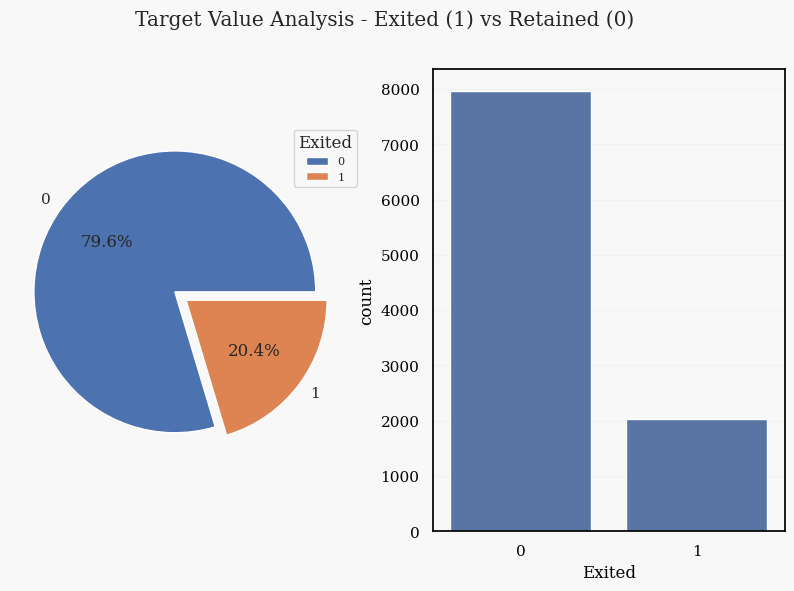

In [10]:
f,ax=plt.subplots(1,2,figsize=(10,6))

labels = data['Exited'].value_counts().index
sizes = data['Exited'].value_counts().values
explode = (0.1, 0) 

ax[0].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
ax[0].set_ylabel('') 
ax[0].legend(loc='upper right', title='Exited', fontsize=8)


sns.countplot(x='Exited', data=data, ax=ax[1])
plt.suptitle('Target Value Analysis - Exited (1) vs Retained (0)')

plt.show()

#### Categorical Variables Analysis

In [11]:
unique_values = data.nunique()
threshold = 12

continuous_features = data.nunique()[data.nunique() > threshold].index.tolist()
categorical_features = data.nunique()[data.nunique() <= threshold].index.tolist()

print(f"Continuous features: {continuous_features}")
print(f"Category features: {categorical_features}")

categorical_features.remove('Exited')


Continuous features: ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
Category features: ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']


/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_6518/3143761988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')


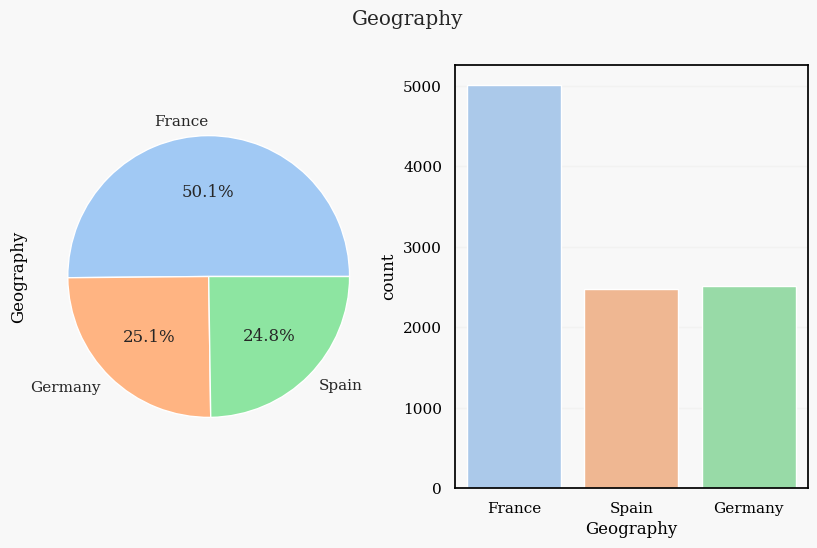

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_6518/3143761988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')


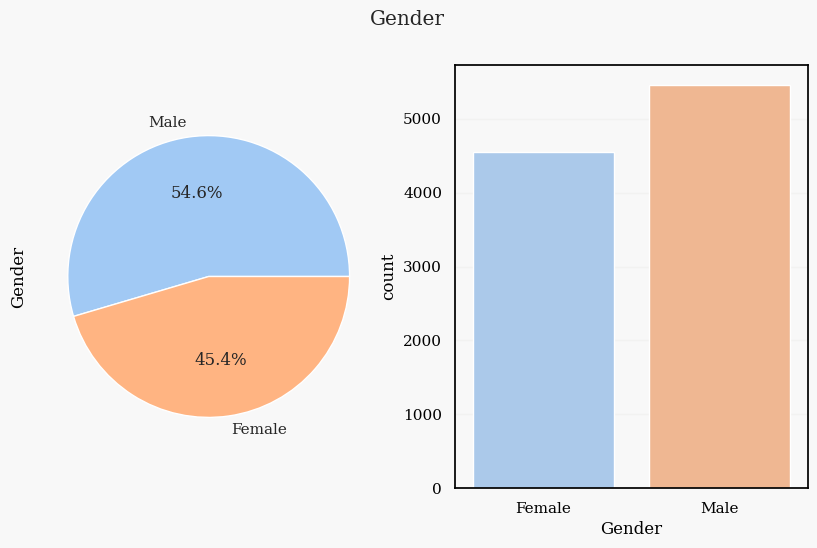

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_6518/3143761988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')


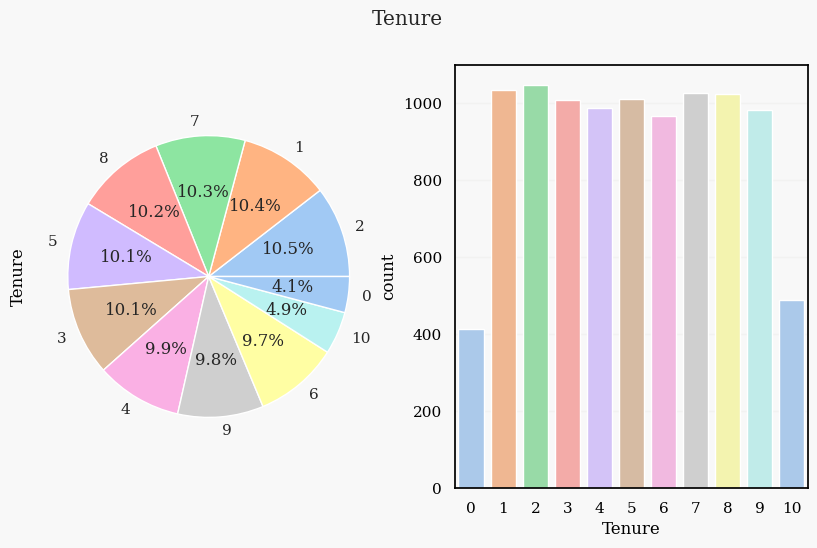

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_6518/3143761988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')


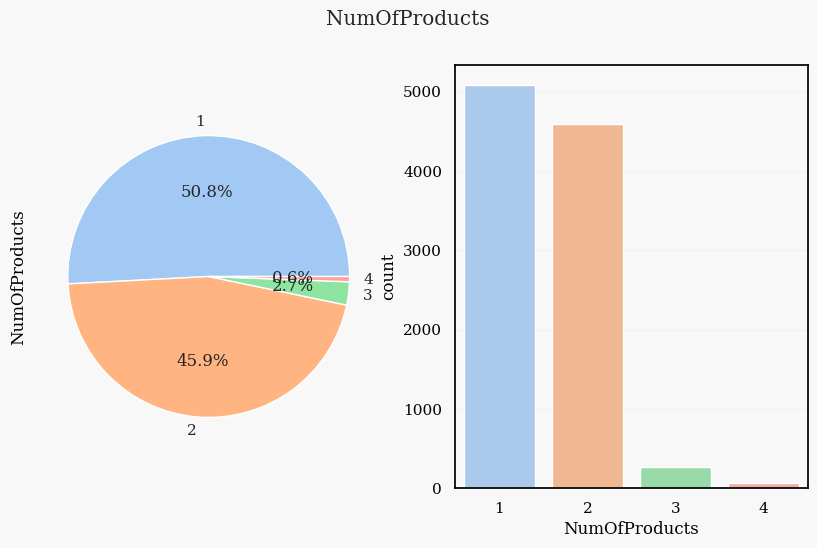

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_6518/3143761988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')


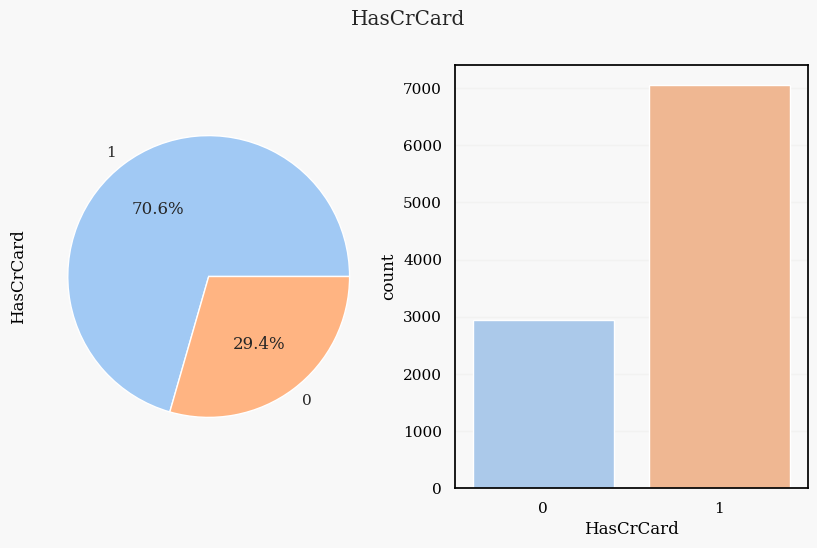

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_6518/3143761988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')


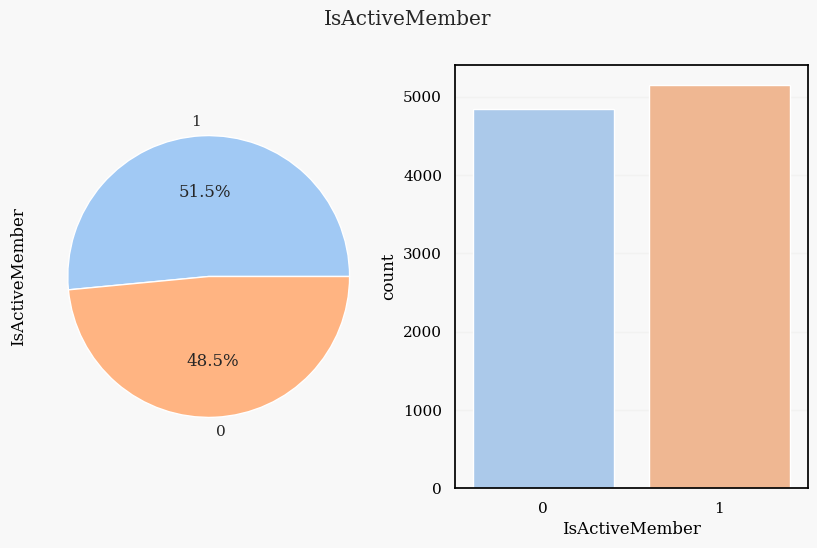

In [12]:
for column in categorical_features:
    f,ax=plt.subplots(1,2,figsize=(10,5.5))
    data[column].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0], colors =sns.color_palette('pastel'))
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')
    plt.suptitle(f'{column}')
    plt.show()

#### Numerical Value Analysis

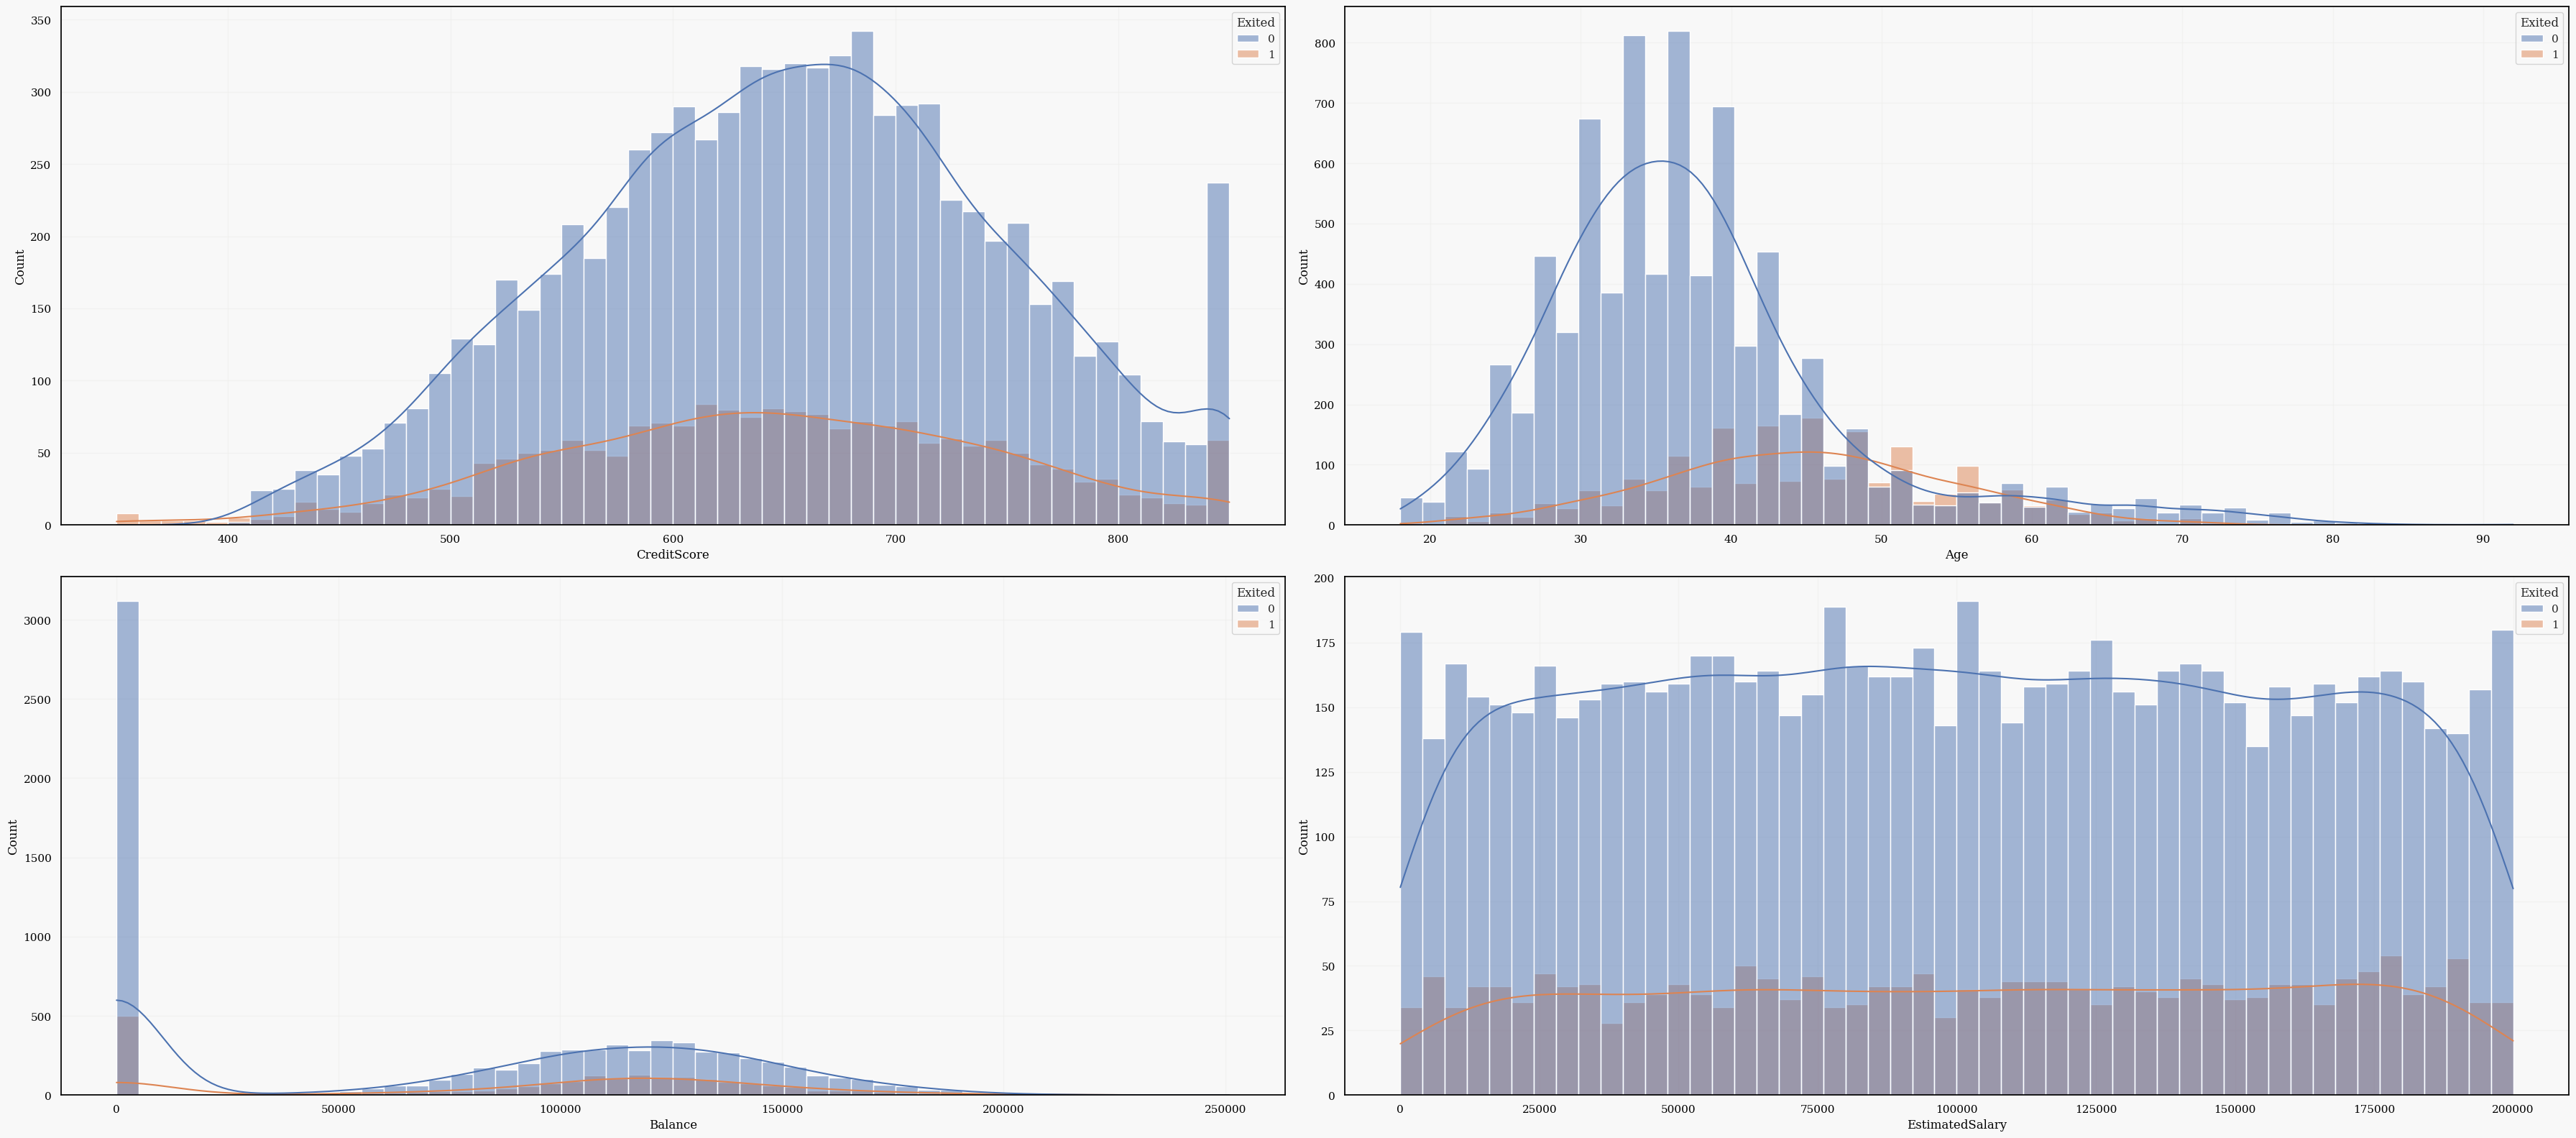

In [13]:
n_rows = (len(continuous_features) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(36, 8 * n_rows))
axes = axes.flatten()

for i, column in enumerate(continuous_features):
    sns.histplot(data=data, x=column, hue="Exited", bins=50, kde=True, ax=axes[i])

if len(continuous_features) % 2 != 0:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

#### Correlation Analysis


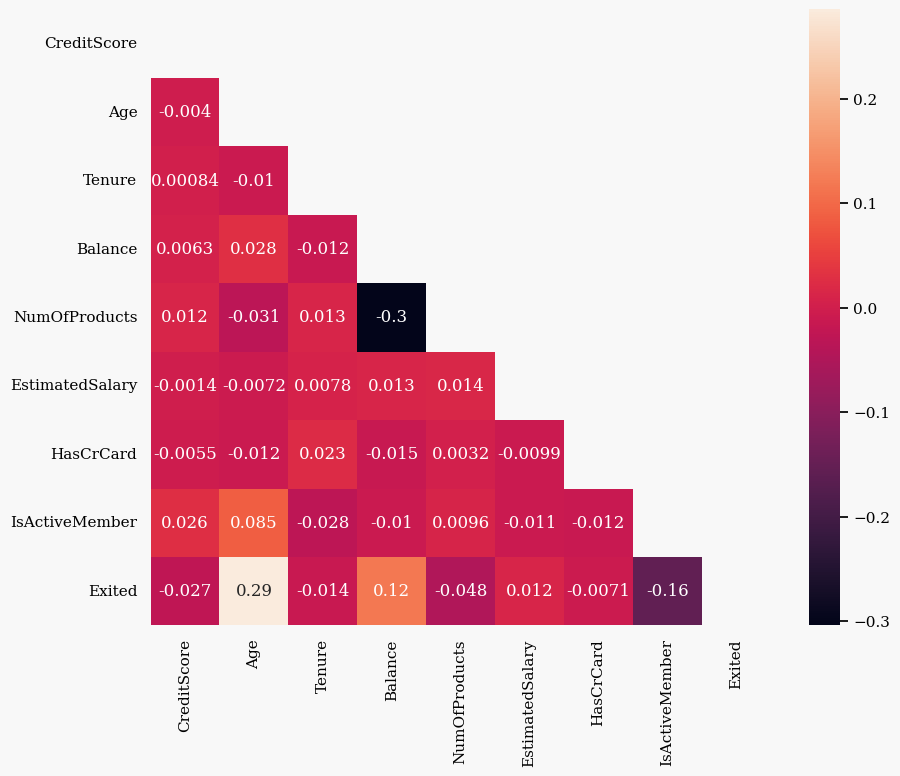

In [15]:
data4 = data[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'HasCrCard', 'IsActiveMember', 'Exited']].copy()
correlation = data4.corr()

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, mask=mask, annot=True)
plt.show()






#### Encoding categorical variables using one-hot encoding 


In [16]:
data_enc = pd.get_dummies(data, columns=['Geography', 'Gender'], drop_first=True, dtype='int64') 


In [17]:
data_enc.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


#### Feature Scaling

In [18]:
scaler = StandardScaler()
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [19]:
data_enc[numerical_features] = scaler.fit_transform(data_enc[numerical_features])

In [20]:
data_enc.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,0,0,1,0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,0,1,0


#### Classification using Random Forest

In [21]:
X = data_enc.drop('Exited', axis=1)
y = data_enc['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.867
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000



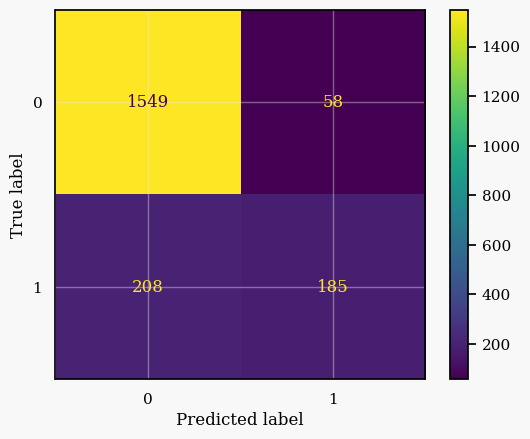

In [22]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # Define a parameter grid to search over
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Initialize a Random Forest classifier
# rf = RandomForestClassifier(random_state=42)

# # Initialize GridSearchCV with 5-fold cross-validation
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# # Fit GridSearchCV to the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and the best model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Evaluate the best model on the test set
# best_model_accuracy = best_model.score(X_test, y_test)
# print(f"Best Model Accuracy: {best_model_accuracy}")
# print(f"Best Parameters: {best_params}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END max_depth=10, min_sa

In [23]:
# Using SMOTE for class balancing
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

In [24]:
balance_check = y_balanced.value_counts()
print(balance_check)

Exited
0    6356
1    6356
Name: count, dtype: int64


In [25]:
rf_classifier_smote = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42
)

rf_classifier_smote.fit(X_balanced, y_balanced)
y_pred = rf_classifier_smote.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# OVerall F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

Accuracy: 0.846
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      1607
           1       0.60      0.64      0.62       393

    accuracy                           0.85      2000
   macro avg       0.76      0.77      0.76      2000
weighted avg       0.85      0.85      0.85      2000

F1 Score: 0.6216216216216216


In [26]:
# OVerall F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

F1 Score: 0.6216216216216216


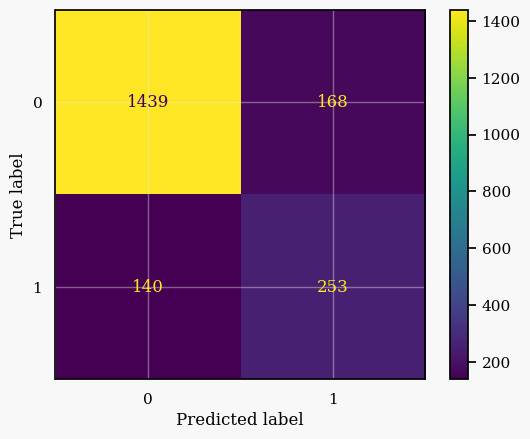

In [27]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

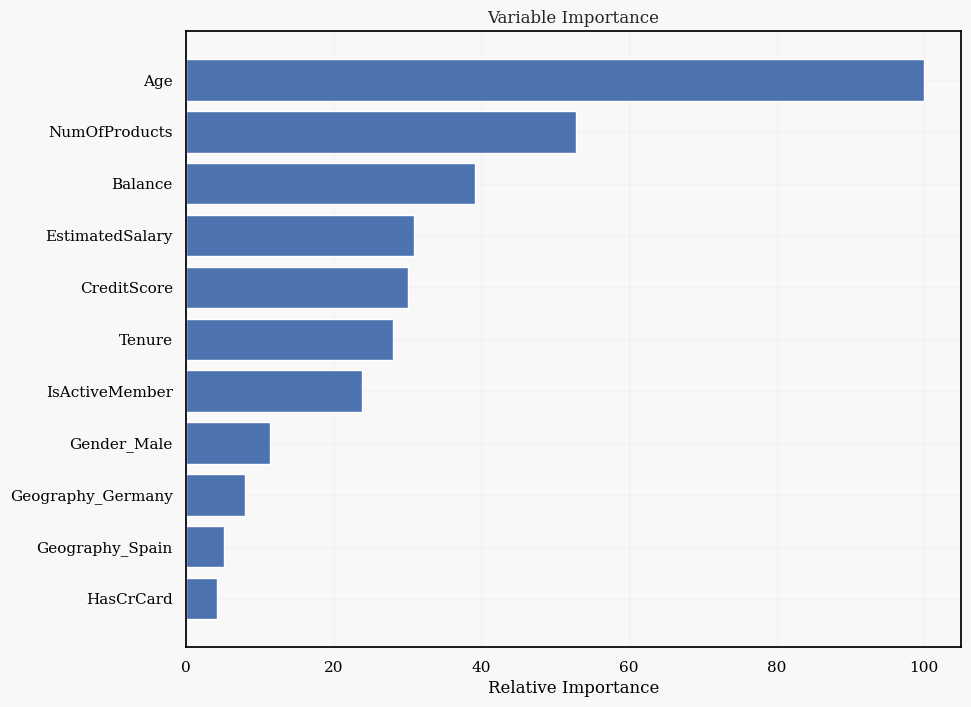

In [28]:
# Feature Importance
feature_importance = rf_classifier_smote.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# plot the feature importance for better visualization
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .05
plt.figure(figsize=(10, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


Exited
0    6356
1    6064
Name: count, dtype: int64
Accuracy: 0.824
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89      1607
           1       0.54      0.66      0.60       393

    accuracy                           0.82      2000
   macro avg       0.73      0.76      0.74      2000
weighted avg       0.84      0.82      0.83      2000



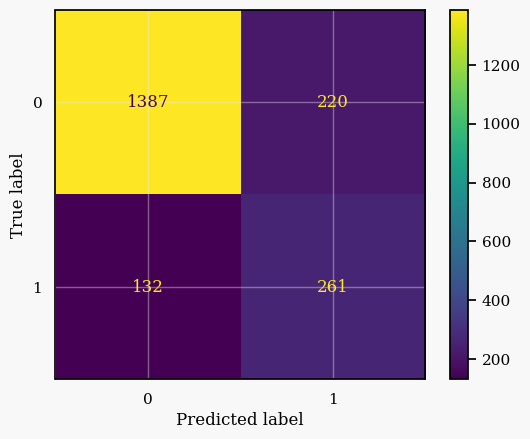

In [29]:
# Use ADASYN for class balancing
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

balance_check = y_adasyn.value_counts()
print(balance_check)

rf_classifier_adasyn = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42
)

rf_classifier_adasyn.fit(X_adasyn, y_adasyn)
y_pred = rf_classifier_adasyn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()



In [30]:
# Use LightGBM model 
import lightgbm as lgb

lgb_classifier = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=30,
    min_child_samples=10,
    random_state=42
)

lgb_classifier.fit(X_balanced, y_balanced)
y_pred = lgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6356, number of negative: 6356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1312
[LightGBM] [Info] Number of data points in the train set: 12712, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy: 0.8635
Classification Report:
               precision    recall  f1-score   support

           0 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


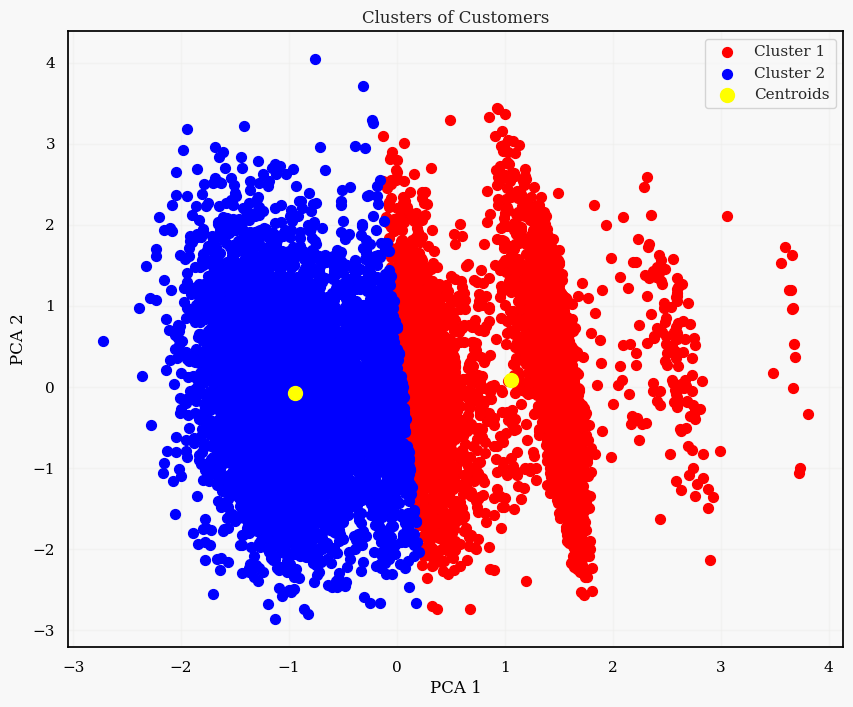

In [31]:
# Apply PCA for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

km = KMeans(n_clusters=2, random_state=42)
clusters = km.fit_predict(X_pca)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[clusters == 0, 0], X_pca[clusters == 0, 1], s=50, c='red', label='Cluster 1')
plt.scatter(X_pca[clusters == 1, 0], X_pca[clusters == 1, 1], s=50, c='blue', label='Cluster 2')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=100, c='yellow', label='Centroids')
plt.title('Clusters of Customers')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


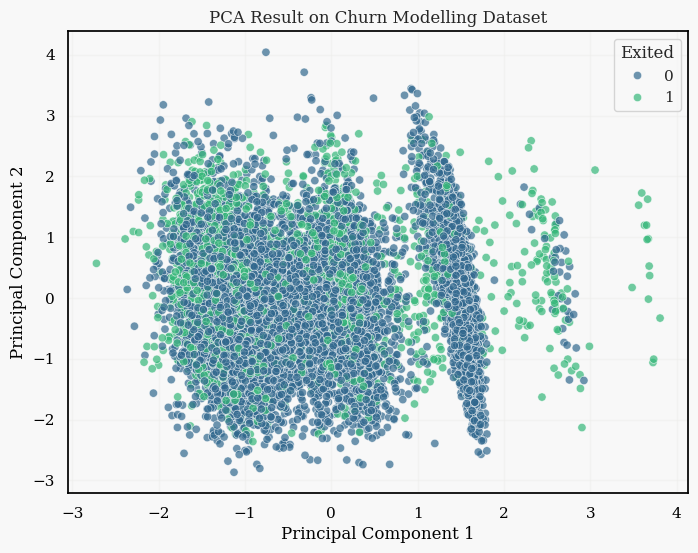

Explained variance by component: [0.18758508 0.14340851]


In [34]:
from sklearn.decomposition import PCA

# You already have your scaled features in X and the target variable in y

# Applying PCA to reduce the features to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Adding the reduced components to the original dataframe for visualization
data_enc['Principal Component 1'] = X_pca[:, 0]
data_enc['Principal Component 2'] = X_pca[:, 1]

# Now, let's visualize the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Principal Component 1', y='Principal Component 2', 
    hue='Exited', data=data_enc, palette='viridis', alpha=0.7
)
plt.title('PCA Result on Churn Modelling Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Exited')
plt.show()

print(f"Explained variance by component: {pca.explained_variance_ratio_}")


In [33]:
X_pca

array([[ 0.17401965,  0.90096512],
       [-0.74965314,  0.81144907],
       [ 0.7893207 , -0.52235724],
       ...,
       [ 0.35402525,  0.14804099],
       [ 0.39809196,  0.51223694],
       [-1.07133872,  0.03736879]])